In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
from pathlib import Path
import magnethub as mh

from utils.data import PRED_SINK, ALL_B_COLS, ALL_H_COLS
from utils.experiments import get_bh_integral_from_two_mats
from run_cnn_inference import run_inference
from utils.data import load_material_csv_files_and_generate_pandas_df

plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    "font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})
IMG_PATH = Path.cwd().parent.parent / 'notebooks' / 'img'
mat2mat_d = {'A': "3C92", "B": "T37", "C": "3C95", "D": "79", "E": "ML95S"}

In [2]:
# load final model stats
CSV_PATH = Path.cwd().parent.parent / 'Model' / 'data' / 'output'
dtype_strategy = {'experiment_uid': 'str', 'model_size': int, "95-perc_rel_err": np.float64}
final_mdl_stats = (pd.read_csv(CSV_PATH / 'trials_meta.csv', dtype=dtype_strategy)
                     .merge( pd.read_csv(CSV_PATH / 'experiments_meta.csv', dtype=dtype_strategy), on='experiment_uid', how='left')
                     .merge(pd.read_csv(CSV_PATH / "final_mdl_test_errs.csv", dtype={'test_err_95th': np.float64}), on=['model_uid', 'material'], how='left')
                     .dropna()
                     .query("tag.str.startswith('final:')", engine='python')
                     .sort_values(["model_size", "material"])
                     .reset_index(drop=True)
                     .query("model_size not in (1460, 1838)")
                   )
final_mdl_stats

,experiment_uid,material,model_uid,seed,fold,avg_rel_err,95-perc_rel_err,99-perc_rel_err,max_rel_err,start_date,end_date,debug,subsample_factor,batch_size,n_folds,predicts_p_directly,n_epochs,tag,model_size,test_err_95th
0,f653e,A,49bfd75b,0,0,0.121726,0.279545,0.532899,2.304586e+06,2024-07-18 15:42:04,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.299380
1,f653e,B,283933b2,0,0,0.029284,0.076732,0.103569,2.725883e+05,2024-07-18 15:56:43,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.075931
2,f653e,C,e14c637b,0,0,0.072577,0.186090,0.276414,1.010282e+06,2024-07-18 16:40:30,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.186988
3,f653e,D,891bfe02,0,0,0.139407,0.392824,0.630137,4.836130e+06,2024-07-18 17:12:21,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.419586
4,f653e,E,415f4d23,0,0,0.088057,0.243370,0.441125,1.818816e+06,2024-07-18 17:16:11,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.265459
5,a7f70,A,4d55f8f7,0,0,0.022831,0.059287,0.088310,3.250690e+05,2024-07-18 13:41:47,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.070709
6,a7f70,B,85605e16,0,0,0.011817,0.031076,0.051803,3.243422e+05,2024-07-18 13:57:50,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.031080
7,a7f70,C,bf8710e3,0,0,0.021330,0.056144,0.087632,3.609858e+05,2024-07-18 14:44:54,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.057358
8,a7f70,D,0f3b4b62,0,0,0.042834,0.119376,0.202652,2.087636e+05,2024-07-18 15:19:14,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.265868
9,a7f70,E,13970759,0,0,0.027249,0.077795,0.121778,5.437307e+05,2024-07-18 15:23:35,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.087752


In [18]:
# Pareto optimum
final_mdl_stats.query("model_size == 906")

,experiment_uid,material,model_uid,seed,fold,avg_rel_err,95-perc_rel_err,99-perc_rel_err,max_rel_err,start_date,end_date,debug,subsample_factor,batch_size,n_folds,predicts_p_directly,n_epochs,tag,model_size,test_err_95th
10,40ce5,A,5d3b4659,0,0,0.015763,0.043545,0.061211,468216.017009,2024-07-18 08:21:29,2024-07-18 10:42:54,False,1,64,1,True,10000,"final: H_ts: 8 -> 4 -> 1, H_s: 8, P: n_scalars...",906,0.052021
11,40ce5,B,b89e2778,0,0,0.012399,0.031285,0.051958,216765.692657,2024-07-18 08:41:23,2024-07-18 10:42:54,False,1,64,1,True,10000,"final: H_ts: 8 -> 4 -> 1, H_s: 8, P: n_scalars...",906,0.032070
12,40ce5,C,9cc9ec6a,0,0,0.017952,0.042924,0.059315,205468.724754,2024-07-18 09:38:59,2024-07-18 10:42:54,False,1,64,1,True,10000,"final: H_ts: 8 -> 4 -> 1, H_s: 8, P: n_scalars...",906,0.043982
13,40ce5,D,7d3f9292,0,0,0.023827,0.067020,0.106718,234449.701565,2024-07-18 10:20:51,2024-07-18 10:42:54,False,1,64,1,True,10000,"final: H_ts: 8 -> 4 -> 1, H_s: 8, P: n_scalars...",906,0.183532
14,40ce5,E,f37feb8f,0,0,0.019661,0.055412,0.081247,427080.110370,2024-07-18 10:26:04,2024-07-18 10:42:54,False,1,64,1,True,10000,"final: H_ts: 8 -> 4 -> 1, H_s: 8, P: n_scalars...",906,0.074081


In [19]:
s = """
       |Material A|Material A|Material B|Material B|Material C|Material C|Material D|Material D|Material E|Material E\n
Team|Error|Size|Error|Size|Error|Size|Error|Size|Error|Size\n
 #1     | 9.6        | 1576       | 5.6        | 1576       | 8.5        | 1576       | 55.3       | 1576       | 13.5       | 1576       \n
 #2     | 8.5        | 90653      | 2.0        | 90653      | 4.5        | 90653      | 15.9       | 16449      | 8.0        | 16449      \n
 #3     | 40.5       | 11012900   | 7.8        | 11012900   | 25.2       | 11012900   | 44.1       | 11012900   | 36.3       | 11012900   \n
 #4     | 4.9        | 8914       | 2.2        | 8914       | 2.9        | 8914       | 20.7       | 8914       | 9.0        | 8914       \n
 #5     | 16.0       | 2396048    | 3.7        | 2396048    | 6.8        | 2396048    | 201.4      | 2396048    | 19.3       | 2396048    \n
 #6     | 4.6        | 25923      | 2.8        | 25923      | 6.8        | 25923      | 39.5       | 25923      | 9.3        | 25923      \n
 #7     | 72.4       | 118785     | 58.0       | 118785     | 66.1       | 118785     | 71.3       | 118785     | 53.7       | 118785     \n
 #8     | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        \n
 #9     | 21.3       | 60         | 7.9        | 60         | 14.4       | 60         | 93.9       | 60         | 21.5       | 60         \n
 #10    | 45.9       | 9728       | 6.9        | 29600      | 26.4       | 21428      | 59.4       | 1740       | 68.4       | 8052       \n
 #11    | 99.8       | 28564      | 88.7       | 28564      | 93.7       | 28564      | 99.3       | 28564      | 97.8       | 28564      \n
 #12    | 19.9       | 86728      | 7.4        | 86728      | 7.7        | 86728      | 65.9       | 86728      | 85.1       | 86728      \n
 #13    | 4.8        | 1755       | 2.2        | 1755       | 3.4        | 1755       | 22.2       | 1755       | 6.6        | 1755       \n
 #14    | 32.1       | 610        | 33.4       | 760        | 27.7       | 748        | 47.1       | 700        | 28.5       | 610        \n
 #15    | 351.2      | 329537     | 138.7      | 329537     | 439.5      | 329537     | 810.1      | 329537     | 152.8      | 329537     \n
 #16    | 38.8       | 81         | 6.9        | 56         | 21.0       | 61         | 50.5       | 23         | 28.2       | 53         \n
 #17    | 26.1       | 139938     | 12.9       | 139938     | 15.6       | 139938     | 79.1       | 139938     | 19.1       | 139938     \n
 #18    | 10.0       | 1084       | 3.7        | 1084       | 5.0        | 1084       | 30.7       | 1084       | 19.9       | 1084       \n
 #19    | 24.5       | 1033729    | 8.0        | 1033729    | 8.9        | 1033729    | 67.9       | 276225     | 118.7      | 1033729    \n
 #20    | 13.1       | 116061     | 6.4        | 116061     | 9.3        | 116061     | 29.9       | 116061     | 25.7       | 116061     \n
 #21    | 7.2        | 1419       | 1.9        | 2197       | 3.5        | 2197       | 29.6       | 1419       | 9.1        | 2454       \n
 #22    | 15.6       | 23000      | 4.3        | 23000      | 9.3        | 23896      | 79.2       | 32546      | 98.0       | 25990      \n
 #23    | 12.4       | 17342      | 3.8        | 17342      | 10.7       | 17342      | 30.0       | 17342      | 14.1       | 17342      \n
 #24    | 15.5       | 4285       | 6.1        | 4285       | 10.1       | 4285       | 67.9       | 4285       | 77.0       | 4285       \n
"""

In [20]:

mat_cols = ['Material '+mat for mat in list("ABCDE")]
df = pd.read_csv(StringIO(s), sep='|', header=[0, 1]).drop(index=7)
for matcol in mat_cols:
    df.loc[:, (matcol, 'Error')] = df.loc[:, (matcol, 'Error')].astype(float)
    df.loc[:, (matcol, 'Size')] = df.loc[:, (matcol, 'Size')].astype(int)
df

Material A           Material B           Material C            \
        Team      Error      Size      Error      Size      Error      Size   
0    #1             9.6      1576        5.6      1576        8.5      1576   
1    #2             8.5     90653        2.0     90653        4.5     90653   
2    #3            40.5  11012900        7.8  11012900       25.2  11012900   
3    #4             4.9      8914        2.2      8914        2.9      8914   
4    #5            16.0   2396048        3.7   2396048        6.8   2396048   
5    #6             4.6     25923        2.8     25923        6.8     25923   
6    #7            72.4    118785       58.0    118785       66.1    118785   
8    #9            21.3        60        7.9        60       14.4        60   
9    #10           45.9      9728        6.9     29600       26.4     21428   
10   #11           99.8     28564       88.7     28564       93.7     28564   
11   #12           19.9     86728        7.4     86728        7.7     86728   
12   #13            4.8      1755        2.2      1755        3.4      1755   
13   #14           32.1       610       33.4       760       27.7       748   
14   #15          351.2    329537      138.7    329537      439.5    329537   
15   #16           38.8        81        6.9        56       21.0        61   
16   #17           26.1    139938       12.9    139938       15.6    139938   
17   #18           10.0      1084        3.7      1084        5.0      1084   
18   #19           24.5   1033729        8.0   1033729        8.9   1033729   
19   #20           13.1    116061        6.4    116061        9.3    116061   
20   #21            7.2      1419        1.9      2197        3.5      2197   
21   #22           15.6     23000        4.3     23000        9.3     23896   
22   #23           12.4     17342        3.8     17342       10.7     17342   
23   #24           15.5      4285        6.1      4285       10.1      4285   

   Material D           Material E            
        Error      Size      Error      Size  
0        55.3      1576       13.5      1576  
1        15.9     16449        8.0     16449  
2        44.1  11012900       36.3  11012900  
3        20.7      8914        9.0      8914  
4       201.4   2396048       19.3   2396048  
5        39.5     25923        9.3     25923  
6        71.3    118785       53.7    118785  
8        93.9        60       21.5        60  
9        59.4      1740       68.4      8052  
10       99.3     28564       97.8     28564  
11       65.9     86728       85.1     86728  
12       22.2      1755        6.6      1755  
13       47.1       700       28.5       610  
14      810.1    329537      152.8    329537  
15       50.5        23       28.2        53  
16       79.1    139938       19.1    139938  
17       30.7      1084       19.9      1084  
18       67.9    276225      118.7   1033729  
19       29.9    116061       25.7    116061  
20       29.6      1419        9.1      2454  
21       79.2     32546       98.0     25990  
22       30.0     17342       14.1     17342  
23       67.9      4285       77.0      4285

In [21]:
df.loc[:, (mat_cols, "Error")]

,Material A,Material B,Material C,Material D,Material E
,Error,Error,Error,Error,Error
0,9.6,5.6,8.5,55.3,13.5
1,8.5,2.0,4.5,15.9,8.0
2,40.5,7.8,25.2,44.1,36.3
3,4.9,2.2,2.9,20.7,9.0
4,16.0,3.7,6.8,201.4,19.3
5,4.6,2.8,6.8,39.5,9.3
6,72.4,58.0,66.1,71.3,53.7
8,21.3,7.9,14.4,93.9,21.5
9,45.9,6.9,26.4,59.4,68.4


In [22]:
df.loc[:, ('Average', "Error")] = df.loc[:, (mat_cols, "Error")].to_numpy().mean(axis=1)
df.loc[:, ('Average', "Size")] = df.loc[:, (mat_cols, "Size")].to_numpy().mean(axis=1)

In [23]:
df.columns

MultiIndex([(   '       ',  'Team'),
            ('Material A', 'Error'),
            ('Material A',  'Size'),
            ('Material B', 'Error'),
            ('Material B',  'Size'),
            ('Material C', 'Error'),
            ('Material C',  'Size'),
            ('Material D', 'Error'),
            ('Material D',  'Size'),
            ('Material E', 'Error'),
            ('Material E',  'Size'),
            (   'Average', 'Error'),
            (   'Average',  'Size')],
           )

In [24]:
df.loc[:, ('       ',  'Team')] = df.loc[:, ('       ',  'Team')].str.strip()

In [25]:
final_mdl_stats

,experiment_uid,material,model_uid,seed,fold,avg_rel_err,95-perc_rel_err,99-perc_rel_err,max_rel_err,start_date,end_date,debug,subsample_factor,batch_size,n_folds,predicts_p_directly,n_epochs,tag,model_size,test_err_95th
0,f653e,A,49bfd75b,0,0,0.121726,0.279545,0.532899,2.304586e+06,2024-07-18 15:42:04,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.299380
1,f653e,B,283933b2,0,0,0.029284,0.076732,0.103569,2.725883e+05,2024-07-18 15:56:43,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.075931
2,f653e,C,e14c637b,0,0,0.072577,0.186090,0.276414,1.010282e+06,2024-07-18 16:40:30,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.186988
3,f653e,D,891bfe02,0,0,0.139407,0.392824,0.630137,4.836130e+06,2024-07-18 17:12:21,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.419586
4,f653e,E,415f4d23,0,0,0.088057,0.243370,0.441125,1.818816e+06,2024-07-18 17:16:11,2024-07-18 17:28:46,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 2, P: n_scalars+1 -> 1",258,0.265459
5,a7f70,A,4d55f8f7,0,0,0.022831,0.059287,0.088310,3.250690e+05,2024-07-18 13:41:47,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.070709
6,a7f70,B,85605e16,0,0,0.011817,0.031076,0.051803,3.243422e+05,2024-07-18 13:57:50,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.031080
7,a7f70,C,bf8710e3,0,0,0.021330,0.056144,0.087632,3.609858e+05,2024-07-18 14:44:54,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.057358
8,a7f70,D,0f3b4b62,0,0,0.042834,0.119376,0.202652,2.087636e+05,2024-07-18 15:19:14,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.265868
9,a7f70,E,13970759,0,0,0.027249,0.077795,0.121778,5.437307e+05,2024-07-18 15:23:35,2024-07-18 15:37:13,False,1,64,1,True,10000,"final: H_ts: 4 -> 1, H_s: 4, P: n_scalars+1 ->...",382,0.087752


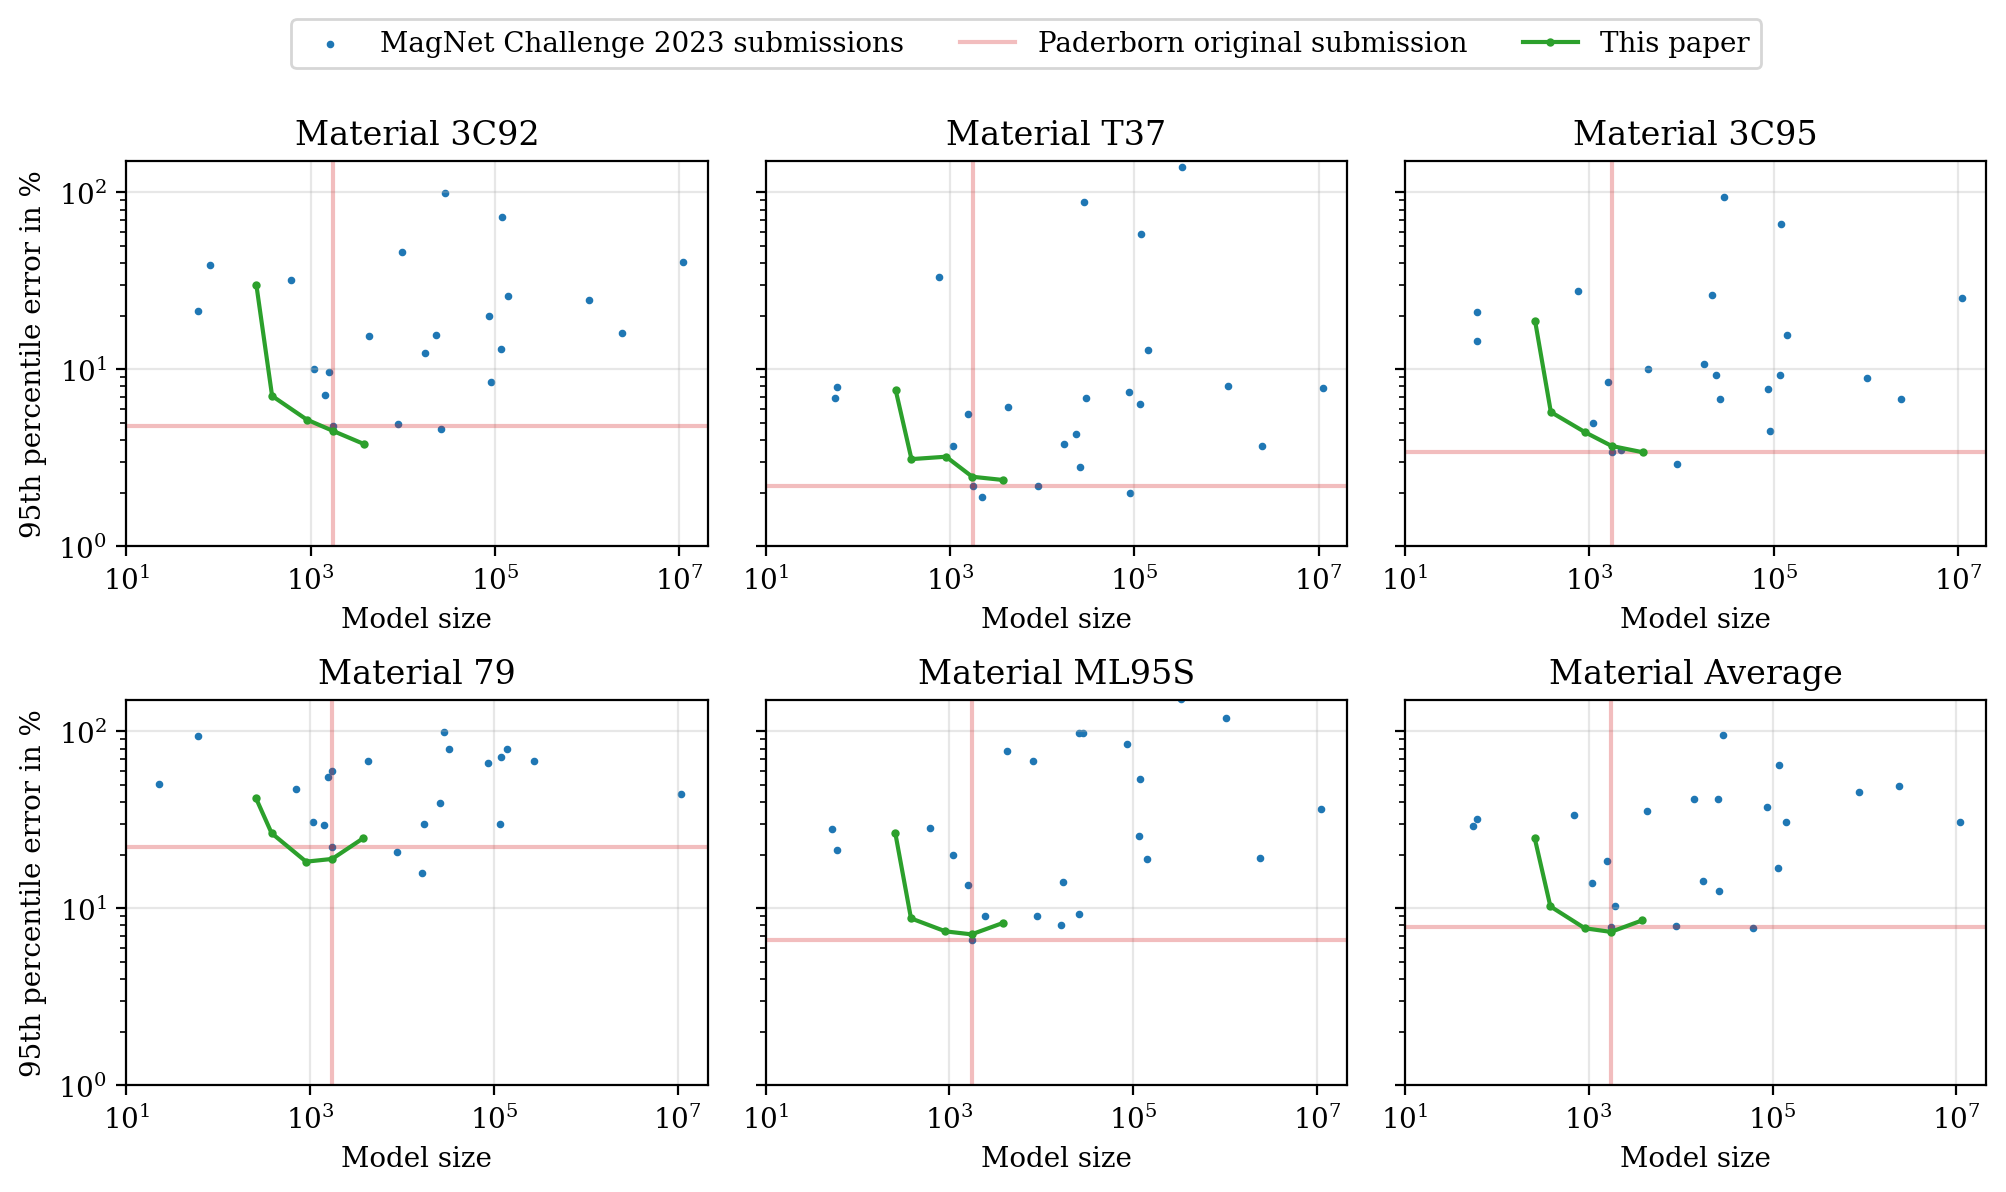

In [26]:
fig, axes = plt.subplots(2, 3, sharex='row', sharey="row", figsize=(12, 6), dpi=200)
SHOW_BLUE_TEAM = '#9'
for matcol, ax in zip(mat_cols + ['Average'], axes.flatten()):
    ax.scatter(df.loc[:, (matcol, 'Size')], df.loc[:, (matcol, 'Error')], s=3.0, label="MagNet Challenge 2023 submissions")
    ax.axvline(1755, color="tab:red", alpha=.3, label='Paderborn original submission')
    ax.axhline(float(df.loc[df.loc[:, (matcol, 'Size')] == 1755, (matcol, 'Error')].iloc[0]), color='tab:red', alpha=.3)
    if "Average" not in matcol:
        final_mdls_df = final_mdl_stats.query(f"material == '{matcol.split(' ')[-1]}'")
    else:
        final_mdls_df = final_mdl_stats.loc[:, ["test_err_95th", "model_size", "experiment_uid"]].groupby("experiment_uid").mean().sort_values("model_size", ascending=True)
    ax.plot(final_mdls_df.model_size, final_mdls_df.loc[:, "test_err_95th"]*100, color='tab:green', marker='o', markersize=2,
            label='This paper')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1, 150)
    ax.set_xlim(10, None)
    ax.set_title("Material " + mat2mat_d.get(matcol.split(' ')[-1], 'Average'))
    ax.set_xlabel('Model size')
    if matcol.endswith(('A', 'D')):
        ax.set_ylabel('95th percentile error in %')
    ax.grid(alpha=0.3)
ax.legend(loc="upper center",
    bbox_to_anchor=(0.5, 1.01),
    ncol=3,
    bbox_transform=fig.transFigure,)
fig.align_ylabels()
fig.subplots_adjust(hspace=.4)
fig.subplots_adjust(wspace=.1)
#fig.tight_layout()
fig.savefig(IMG_PATH / "we_vs_all_contenders.pdf", dpi=300, bbox_inches="tight")

In [27]:
df.loc[:, 'mean_error'] = np.column_stack([df.loc[:, (matcol, 'Error')].to_numpy() for matcol in mat_cols]).mean(axis=1)
df.sort_values(by='mean_error').iloc[:10, :]

Material A         Material B         Material C          \
      Team      Error    Size      Error    Size      Error    Size   
1       #2        8.5   90653        2.0   90653        4.5   90653   
12     #13        4.8    1755        2.2    1755        3.4    1755   
3       #4        4.9    8914        2.2    8914        2.9    8914   
20     #21        7.2    1419        1.9    2197        3.5    2197   
5       #6        4.6   25923        2.8   25923        6.8   25923   
17     #18       10.0    1084        3.7    1084        5.0    1084   
22     #23       12.4   17342        3.8   17342       10.7   17342   
19     #20       13.1  116061        6.4  116061        9.3  116061   
0       #1        9.6    1576        5.6    1576        8.5    1576   
15     #16       38.8      81        6.9      56       21.0      61   

   Material D         Material E         Average           mean_error  
        Error    Size      Error    Size   Error      Size             
1        15.9   16449        8.0   16449    7.78   60971.4       7.78  
12       22.2    1755        6.6    1755    7.84    1755.0       7.84  
3        20.7    8914        9.0    8914    7.94    8914.0       7.94  
20       29.6    1419        9.1    2454   10.26    1937.2      10.26  
5        39.5   25923        9.3   25923    12.6   25923.0       12.6  
17       30.7    1084       19.9    1084   13.86    1084.0      13.86  
22       30.0   17342       14.1   17342    14.2   17342.0       14.2  
19       29.9  116061       25.7  116061   16.88  116061.0      16.88  
0        55.3    1576       13.5    1576    18.5    1576.0       18.5  
15       50.5      23       28.2      53   29.08      54.8      29.08

In [28]:
df.loc[:, 'median_error'] = np.median(np.column_stack([df.loc[:, (matcol, 'Error')].to_numpy() for matcol in mat_cols]), axis=1)
df.sort_values(by='median_error').iloc[:10, :]

Material A         Material B         Material C          \
      Team      Error    Size      Error    Size      Error    Size   
12     #13        4.8    1755        2.2    1755        3.4    1755   
3       #4        4.9    8914        2.2    8914        2.9    8914   
5       #6        4.6   25923        2.8   25923        6.8   25923   
20     #21        7.2    1419        1.9    2197        3.5    2197   
1       #2        8.5   90653        2.0   90653        4.5   90653   
0       #1        9.6    1576        5.6    1576        8.5    1576   
17     #18       10.0    1084        3.7    1084        5.0    1084   
22     #23       12.4   17342        3.8   17342       10.7   17342   
19     #20       13.1  116061        6.4  116061        9.3  116061   
23     #24       15.5    4285        6.1    4285       10.1    4285   

   Material D         Material E         Average           mean_error  \
        Error    Size      Error    Size   Error      Size              
12       22.2    1755        6.6    1755    7.84    1755.0       7.84   
3        20.7    8914        9.0    8914    7.94    8914.0       7.94   
5        39.5   25923        9.3   25923    12.6   25923.0       12.6   
20       29.6    1419        9.1    2454   10.26    1937.2      10.26   
1        15.9   16449        8.0   16449    7.78   60971.4       7.78   
0        55.3    1576       13.5    1576    18.5    1576.0       18.5   
17       30.7    1084       19.9    1084   13.86    1084.0      13.86   
22       30.0   17342       14.1   17342    14.2   17342.0       14.2   
19       29.9  116061       25.7  116061   16.88  116061.0      16.88   
23       67.9    4285       77.0    4285   35.32    4285.0      35.32   

   median_error  
                 
12          4.8  
3           4.9  
5           6.8  
20          7.2  
1           8.0  
0           9.6  
17         10.0  
22         12.4  
19         13.1  
23         15.5

# Run Inference with final models (one-time run)

In [4]:
final_test_raw = Path.cwd().parent.parent / 'Model' / 'data' / 'input'/ 'raw' / 'final-testing' 
final_mdl_stats.loc[:, "test_err_99th"] = 1000.0
final_mdl_stats.loc[:, "test_err_95th"] = 1000.0
final_mdl_stats.loc[:, "test_err_avg"] = 1000.0

for mdl_id, mat_lbl_pre, mdl_size in final_mdl_stats.loc[:, ['model_uid', 'material', 'model_size']].to_numpy():
    mat_lbl = mat2mat_d[mat_lbl_pre]
    df = load_material_csv_files_and_generate_pandas_df(final_test_raw / mat_lbl, training=True)
    df = df.drop(columns=[c for c in df if c.startswith("H_t_")])  # drop H cols 
    ploss_gt = df.pop('ploss')
    ploss_hat = run_inference(mdl_id, df)
    err = np.abs(ploss_hat - ploss_gt)/ploss_gt
    err_95th_quantile = np.quantile(err, 0.95)
    err_avg = np.mean(err)
    err_99th_quantile = np.quantile(err, 0.99)
    print(f"{mdl_id} {mat_lbl} {mdl_size}: avg: {err_avg:.3f} 95th: {err_95th_quantile:.3f} 99th: {err_99th_quantile:.3f}")

    final_mdl_stats.loc[(final_mdl_stats.model_uid == mdl_id) & (final_mdl_stats.material == mat_lbl_pre), "test_err_95th"] = err_95th_quantile
    final_mdl_stats.loc[(final_mdl_stats.model_uid == mdl_id) & (final_mdl_stats.material == mat_lbl_pre), "test_err_99th"] = err_99th_quantile
    final_mdl_stats.loc[(final_mdl_stats.model_uid == mdl_id) & (final_mdl_stats.material == mat_lbl_pre), "test_err_avg"] = err_avg
    

49bfd75b 3C92 258: avg: 0.118 95th: 0.299 99th: 0.514
283933b2 T37 258: avg: 0.029 95th: 0.076 99th: 0.104
e14c637b 3C95 258: avg: 0.073 95th: 0.187 99th: 0.288
891bfe02 79 258: avg: 0.155 95th: 0.420 99th: 0.617
415f4d23 ML95S 258: avg: 0.101 95th: 0.265 99th: 0.390
4d55f8f7 3C92 382: avg: 0.026 95th: 0.071 99th: 0.107
85605e16 T37 382: avg: 0.012 95th: 0.031 99th: 0.054
bf8710e3 3C95 382: avg: 0.021 95th: 0.057 99th: 0.087
0f3b4b62 79 382: avg: 0.087 95th: 0.266 99th: 0.597
13970759 ML95S 382: avg: 0.032 95th: 0.088 99th: 0.143
5d3b4659 3C92 906: avg: 0.018 95th: 0.052 99th: 0.083
b89e2778 T37 906: avg: 0.012 95th: 0.032 99th: 0.051
9cc9ec6a 3C95 906: avg: 0.018 95th: 0.044 99th: 0.062
7d3f9292 79 906: avg: 0.064 95th: 0.184 99th: 0.451
f37feb8f ML95S 906: avg: 0.028 95th: 0.075 99th: 0.118
47843422 3C92 1742: avg: 0.016 95th: 0.045 99th: 0.076
995f5983 T37 1742: avg: 0.010 95th: 0.025 99th: 0.044
0cd93dee 3C95 1742: avg: 0.014 95th: 0.037 99th: 0.060
c1eeeeac 79 1742: avg: 0.064 95t

In [16]:
final_mdl_stats.loc[:, ['model_uid', 'material', 'test_err_95th']].to_csv(CSV_PATH / 'final_mdl_test_errs.csv', index=False)

# Plot H predictions of final models on test set

In [3]:
final_test_raw = Path.cwd().parent.parent / 'Model' / 'data' / 'input'/ 'raw' / 'final-testing' 

In [4]:
# get H ground truth
gt_d = {}
mat_lbl_l = final_mdl_stats.material.map(mat2mat_d).unique().tolist()
for mat_lbl in mat_lbl_l:
    df = load_material_csv_files_and_generate_pandas_df(final_test_raw / mat_lbl, training=True)
    gt_d[mat_lbl] = df
for mat, df_ in gt_d.items():
    h_df = df_.loc[:, ALL_H_COLS]
    print(f"{mat} {h_df.shape=}")

3C92 h_df.shape=(7651, 1024)
T37 h_df.shape=(3172, 1024)
3C95 h_df.shape=(5357, 1024)
79 h_df.shape=(7299, 1024)
ML95S h_df.shape=(3738, 1024)


In [5]:
# get our H predictions
mdl_uids_df = final_mdl_stats.query("model_size == 906").loc[:, ['material', 'model_uid']].assign(material=lambda x: x.material.map(mat2mat_d))
h_ours_pred_d = {}
p_ours_pred_d = {}
for _, (mat_lbl, uid) in mdl_uids_df.iterrows():
    for fh in PRED_SINK.glob(f"CNN_H_preds_test*_{uid}.csv"):
        print(fh.name)
        h_ours_pred_d[mat_lbl] = pd.read_csv(fh, header=None)
        p_ours_pred_d[mat_lbl] = pd.read_csv(fh.with_stem(fh.stem.replace('_H_', '_P_')), header=None)
for mat_lbl, h in h_ours_pred_d.items():
    print(mat_lbl, h.shape)

CNN_H_preds_test_A_5d3b4659.csv
CNN_H_preds_test_B_b89e2778.csv
CNN_H_preds_test_C_9cc9ec6a.csv
CNN_H_preds_test_D_7d3f9292.csv
CNN_H_preds_test_E_f37feb8f.csv
3C92 (7651, 1024)
T37 (3172, 1024)
3C95 (5357, 1024)
79 (7299, 1024)
ML95S (3738, 1024)


In [35]:
# get Sydney model H predictions
h_sydney_pred_d = {}
p_sydney_pred_d = {}
mat_lbl_l = final_mdl_stats.material.map(mat2mat_d).unique().tolist()
sydney_result_path = Path.cwd().parent.parent.parent / 'official_magnet_challenge_2023' / 'models' / 'Sydney' / 'Model' / 'Testing' / 'Result'
for mat_lbl in list("ABCDE"):
    h_pred_128 = np.roll(pd.read_csv(sydney_result_path /f'H_pred_{mat_lbl}_wk.csv').to_numpy(), shift=16)
    q_p = np.arange(1024)
    s_p = np.arange(128) * 1024 / 128
    h_pred_1024 = np.row_stack([np.interp(q_p, s_p, h_pred_128[i]) for i in range(h_pred_128.shape[0])])
    h_sydney_pred_d[mat2mat_d[mat_lbl]] = h_pred_1024

    p_sydney_pred_d[mat2mat_d[mat_lbl]] = pd.read_csv(sydney_result_path / f"Volumetric_Loss_{mat_lbl}_wk.csv", header=None).iloc[:, -1].to_numpy().ravel()


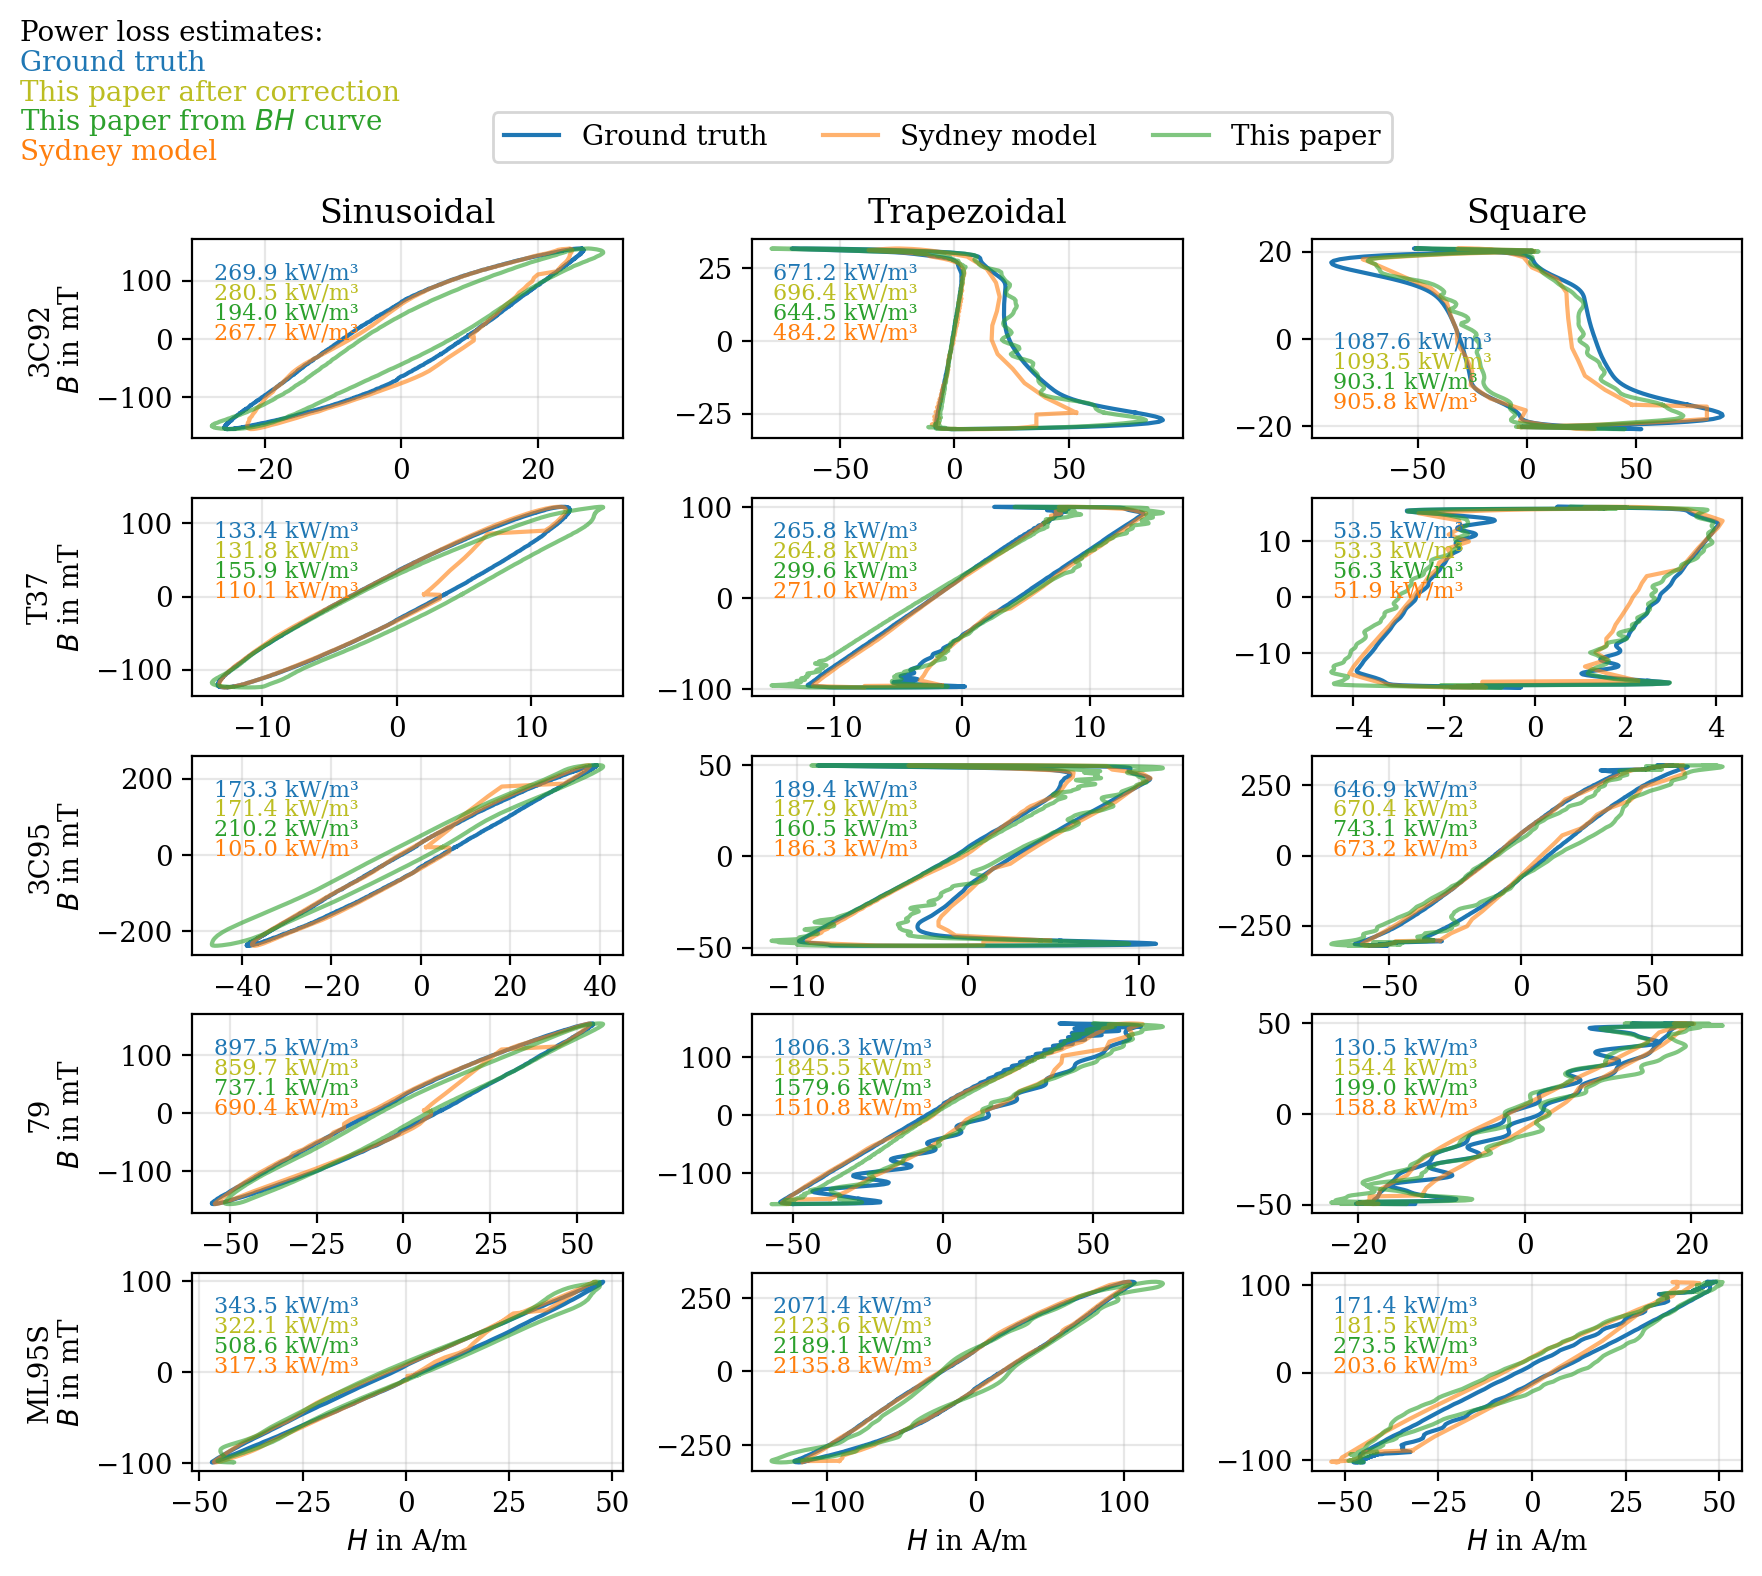

In [36]:
fig, axes = plt.subplots(5, 3, figsize=(10, 8))

indices_to_plot_d = {
    '3C92': (10, 100, 7650),
    'T37': (10, 100, 3100),
    '3C95': (4000, 200, 5200),
    '79': (14, 130, 7200),
    'ML95S': (30, 1200, 1000),
}  # arbitrary

text_opts = dict(fontdict={'size':8})

for m_i, mat_lbl in enumerate(mat_lbl_l):
    df_gt = gt_d[mat_lbl]
    b_field = df_gt.loc[:, ALL_B_COLS].to_numpy()
    h_gt = df_gt.loc[:, ALL_H_COLS].to_numpy()
    h_our_pred = h_ours_pred_d[mat_lbl].to_numpy()
    h_sydney_pred = h_sydney_pred_d[mat_lbl]
    for j, ind_to_plot in enumerate(indices_to_plot_d[mat_lbl]):
        time_ix = np.hstack([np.arange(b_field.shape[1]), 0])
        b_field_i = b_field[ind_to_plot, time_ix] * 1000
        h_gt_i = h_gt[ind_to_plot, time_ix]
        h_our_pred_i = h_our_pred[ind_to_plot, time_ix]
        h_sydney_pred_i = h_sydney_pred[ind_to_plot, time_ix]
        ax = axes[m_i, j]
        ax.plot(h_gt_i, b_field_i, label='Ground truth')
        ax.plot(h_sydney_pred_i, b_field_i, label='Sydney model', alpha=0.6)
        ax.plot(h_our_pred_i, b_field_i, label='This paper', alpha=0.6)
        p_sydney = get_bh_integral_from_two_mats(df_gt.freq.iloc[ind_to_plot], b_field[[ind_to_plot]], h_sydney_pred[[ind_to_plot]])[0]
        p_ours = get_bh_integral_from_two_mats(df_gt.freq.iloc[ind_to_plot], b_field[[ind_to_plot]], h_our_pred[[ind_to_plot]])[0]
        p_ours_corrected = p_ours_pred_d[mat_lbl].iloc[ind_to_plot].item()
        text_x = 0.05
        ax.text(text_x, 0.8 if not (j == 2 and m_i == 0) else 0.45, f"{df_gt.iloc[ind_to_plot, :].loc['ploss']*1e-3:.1f} kW/m³",  color='tab:blue', transform=ax.transAxes, **text_opts)
        ax.text(text_x, 0.7 if not (j == 2 and m_i == 0) else 0.35, f"{p_ours_corrected*1e-3:.1f} kW/m³", color='tab:olive', transform=ax.transAxes, **text_opts)
        ax.text(text_x, 0.6 if not (j == 2 and m_i == 0) else 0.25, f"{p_ours*1e-3:.1f} kW/m³", color='tab:green', transform=ax.transAxes, **text_opts)
        ax.text(text_x, 0.5 if not (j == 2 and m_i == 0) else 0.15, f"{p_sydney*1e-3:.1f} kW/m³", color='tab:orange', transform=ax.transAxes, **text_opts)

text_x = -0.4
axes[0, 0].text(text_x, 2, "Power loss estimates:", transform=axes[0, 0].transAxes, fontdict={'size':10})
axes[0, 0].text(text_x, 1.85, "Ground truth", transform=axes[0, 0].transAxes, color='tab:blue', fontdict={'size':10})
axes[0, 0].text(text_x, 1.7, "This paper after correction", transform=axes[0, 0].transAxes, color='tab:olive', fontdict={'size':10})
axes[0, 0].text(text_x, 1.55, "This paper from $BH$ curve", transform=axes[0, 0].transAxes, color='tab:green', fontdict={'size':10})
axes[0, 0].text(text_x, 1.4, "Sydney model", transform=axes[0, 0].transAxes, color='tab:orange', fontdict={'size':10})

for ax, mat_lbl in zip(axes[:, 0], mat_lbl_l):
    ax.set_ylabel(mat_lbl+"\n$B$ in mT")
for ax in axes[-1, :]:
    ax.set_xlabel("$H$ in A/m")
axes[0, 0].set_title("Sinusoidal")
axes[0, 1].set_title("Trapezoidal")
axes[0, 2].set_title("Square")
axes[0, 0].legend(ncol=3, loc='lower center', bbox_to_anchor=(.5, 0.92),bbox_transform=fig.transFigure, frameon=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.align_ylabels()

In [37]:
fig.savefig(IMG_PATH / "bh_loops_comparison.pdf", dpi=300, bbox_inches="tight")

## Plot Error histograms on Power loss

In [38]:
stenglein_paths = CSV_PATH / 'stenglein'
stenglein_ploss_d = {}
for ploss_csv in stenglein_paths.glob('*.csv'):
    mat_lbl = ploss_csv.stem.split("_")[0]
    stenglein_ploss_d[mat_lbl] = pd.read_csv(ploss_csv, index_col=0).iloc[:, 0]


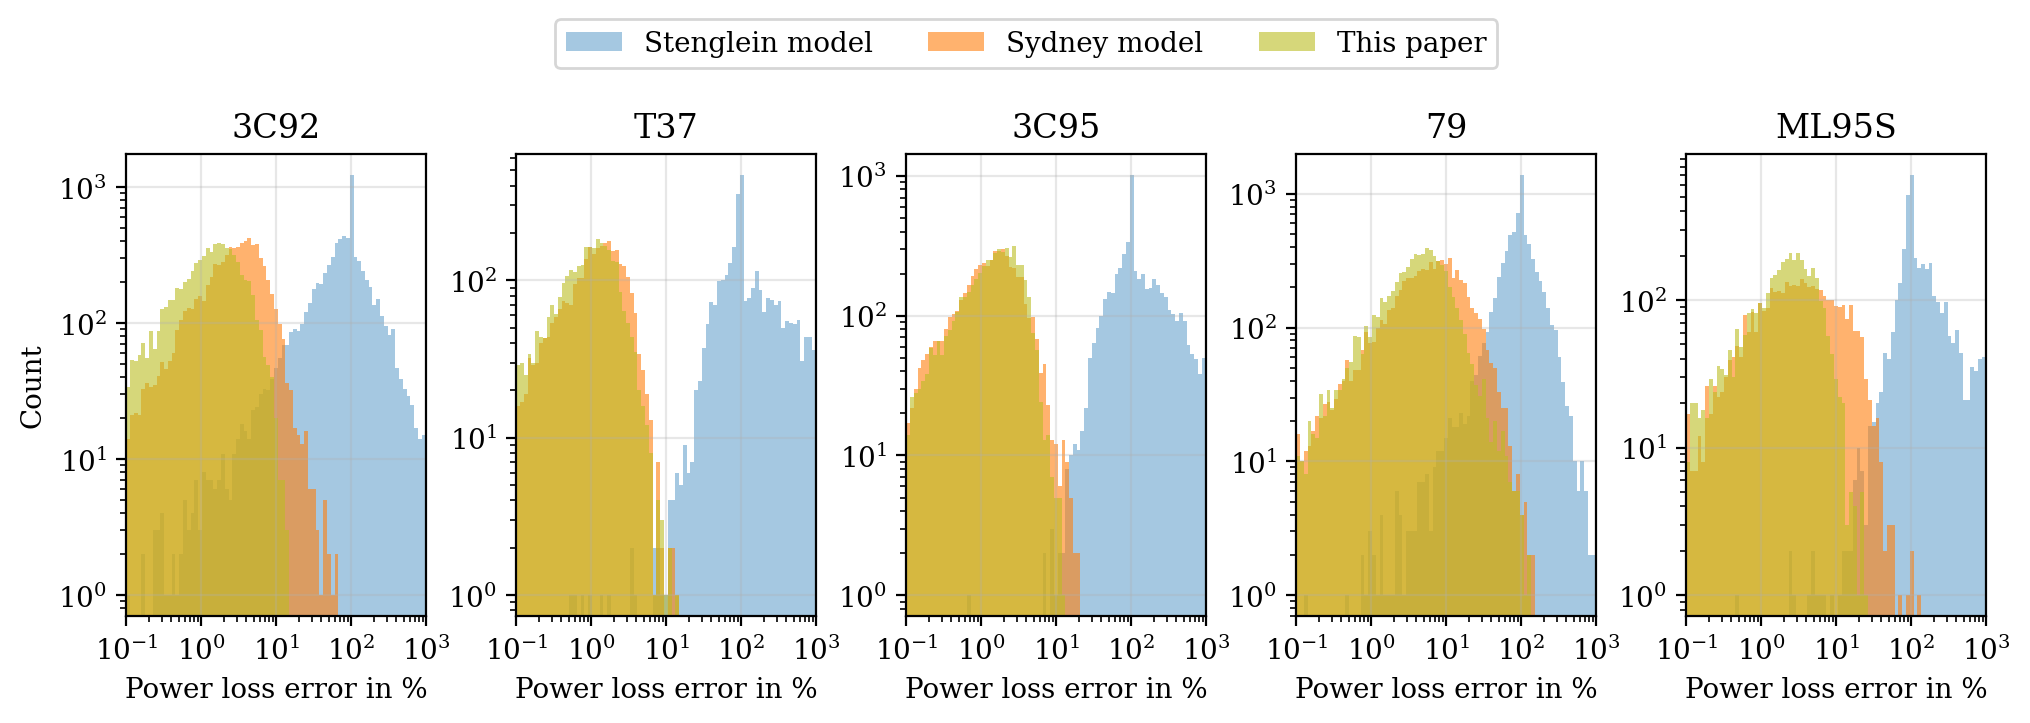

In [47]:
# plot error histograms
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax, mat_lbl in zip(axes.flatten(), list(mat2mat_d.values())):
    ploss_gt = gt_d[mat_lbl].loc[:, 'ploss']
    ax.hist(100 * np.abs(stenglein_ploss_d[mat_lbl] - ploss_gt) / ploss_gt, bins=10**np.linspace(-1, 4, 100), alpha=0.4, range=(0, 1000), log=True, label='Stenglein model')
    ax.hist(100 * np.abs(p_sydney_pred_d[mat_lbl] - ploss_gt) / ploss_gt, bins=10**np.linspace(-1, 4, 100), alpha=0.6, range=(0, 1000), log=True, label='Sydney model')
    ax.hist(100 * np.abs(p_ours_pred_d[mat_lbl].iloc[:, 0].to_numpy() - ploss_gt) / ploss_gt, bins=10**np.linspace(-1, 4, 100), alpha=0.6, range=(0, 1000), log=True, label='This paper', color='tab:olive')
    ax.set_xlabel('Power loss error in %')
    ax.set_xlim(0.1, 1000)
    ax.set_xscale('log')
    ax.set_title(mat_lbl)
axes[0].set_ylabel('Count')
fig.subplots_adjust(wspace=0.3)
axes[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure, frameon=True)

In [45]:
fig.savefig(IMG_PATH / "err_histograms.pdf", dpi=300, bbox_inches="tight")